### Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import selfies as sf
from torch.utils.data import DataLoader
from tqdm import tqdm
import math
from rdkit import Chem
from rdkit.Chem import Draw
import plotly.express as px
from IPython.display import display
from sklearn.linear_model import Ridge

In [2]:
skipped_molecules = ''

df = pd.read_csv("../smiles_selfies_full.csv")

df['tokens'] = df['selfies'].apply(lambda x: list(sf.split_selfies(x)))

all_tokens =  [tok for seq in df['tokens'] for tok in seq]
vocab = sorted(set(all_tokens))
#MAKS = "<MASK>"
PAD = "<PAD>"
SOS = "<SOS>"
EOS = "<EOS>"
vocab = [PAD, SOS, EOS] + vocab
vocab_size = len(vocab)

tok2id = {tok: idx for idx, tok in enumerate(vocab)}
id2tok = {idx: tok for tok, idx in tok2id.items()}

def full_molecule_tokens_to_ids(tokens, tok2id):
    return np.array([1] + [tok2id[t] for t in tokens] + [2])

df['token_ids'] = df['tokens'].apply(lambda toks: full_molecule_tokens_to_ids(toks, tok2id))
df['lenghts'] = df['token_ids'].apply(len)

sequences = df['token_ids'].tolist()
max_len = max(len(seq) for seq in sequences)
padded_data = np.zeros((len(sequences), max_len), dtype=sequences[0].dtype)

for i, seq in enumerate(sequences):
    padded_data[i, :len(seq)] = seq

data = padded_data#[:100_000]
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, shuffle=True)

print(f"Data shapes: Train {train_data.shape}, Val {val_data.shape}, Test {test_data.shape}")

Data shapes: Train (635522, 77), Val (79440, 77), Test (79441, 77)


In [3]:
@torch.no_grad()
def accuracy(model, loader, pad_id=0, device='cuda'):
    model.eval()
    total_tok = total_correct = total_seq = perfect = 0
    for x in loader:
        x = x.to(device)
        logits, _, _, _ = model(x, mode='eval')
        for i, logit in enumerate(logits):
            pred = logit.argmax(-1)      # [L_pred]
            true = x[i]
            true_len = (true != pad_id).sum().item()
            if true_len == 0:
                continue
            if len(pred) < true_len:
                pad = torch.full(
                    (true_len - len(pred),),
                    pad_id,
                    device=pred.device,
                    dtype=pred.dtype
                )
                pred = torch.cat([pred, pad], dim=0)
            else:
                pred = pred[:true_len]
            true = true[:true_len]
            correct = (pred == true)
            total_correct += correct.sum().item()
            total_tok += true_len
            perfect += int(correct.all())
            total_seq += 1
    return (total_correct / max(total_tok, 1),perfect / max(total_seq, 1))

### Model
VAE with non autoregressive transformer as an decoder, with head for predicting lenght of molecule SELFIES 

In [104]:
import torch 
import torch.nn.functional as F
import math
import torch.nn as nn


class PositionalEmbedding(nn.Module):
    def __init__(self, max_len, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        pe = torch.zeros(max_len, hidden_size)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_size, 2).float() * (-math.log(10000.0) / hidden_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        if x.dim() == 3:
            B, T, _ = x.shape
        elif x.dim() == 2:
            B, T = x.shape
        if T <= self.pe.size(0):
            pe = self.pe[:T]  
        else:
            device = x.device
            H = self.hidden_size
            position = torch.arange(T, dtype=torch.float, device=device).unsqueeze(1)  
            div_term = torch.exp(torch.arange(0, H, 2, device=device).float() * (-math.log(10000.0)/H))
            pe = torch.zeros(T, H, device=device)
            pe[:, 0::2] = torch.sin(position * div_term)
            pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)  

class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super().__init__()
        self.d = hidden_size // num_heads
        self.num_heads = num_heads
        self.W_q = nn.Linear(hidden_size, hidden_size, bias=False)
        self.W_k = nn.Linear(hidden_size, hidden_size, bias=False)
        self.W_v = nn.Linear(hidden_size, hidden_size, bias=False)
        self.W_o = nn.Linear(hidden_size, hidden_size, bias=False)
        self.norm1 = nn.LayerNorm(hidden_size)
        self.ff = nn.Sequential(
            nn.Linear(hidden_size, 4*hidden_size),
            nn.GELU(),
            nn.Dropout(p=0.1),
            nn.Linear(4*hidden_size, hidden_size),
            nn.Dropout(p=0.1)
        )
        self.norm2 = nn.LayerNorm(hidden_size)

    def forward(self, q, k, v, pad_mask=None, causal=False):   # [B, T, H]
        B, T_q, H = q.shape
        _, T_v, _ = v.shape
        Q = self.W_q(q)     # [B, T, num_heads * H]
        K = self.W_k(k)
        V = self.W_v(v)
        Q = Q.view(B, self.num_heads, T_q, self.d) # [B, A, T, H]
        K = K.view(B, self.num_heads, T_v, self.d)
        V = V.view(B, self.num_heads, T_v, self.d)

        attn_logits = torch.einsum('baih,bajh->baij', Q, K)    # [B, A, T, H] @ [B, A, H, T] = [B, A, T, T]

        if pad_mask is not None:
            key_mask = pad_mask[:, None, None, :]  # [B,1,1,T_k]
            attn_logits = attn_logits.masked_fill(~key_mask, float('-inf'))

        attn = F.softmax(attn_logits / math.sqrt(self.d), dim=-1)

        if pad_mask is not None:
            query_mask = pad_mask[:, None, :, None]  # [B,1,T_q,1]
            attn = attn * query_mask.float()

        h = torch.einsum('baij,bajh->baih',attn, V)  # [B, A, T, H]
        h = h.view(B, T_q, H)  # [B, T, A*H]
        h = self.W_o(h)     # [B, T, H]
        
        h = self.norm1(q + h)
        h = self.norm2(h + self.ff(h))
        return h
    
def phi(x):
    return F.elu(x) + 1

class LinearMultiHeadAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super().__init__()
        assert hidden_size % num_heads == 0
        
        self.num_heads = num_heads
        self.d = hidden_size // num_heads

        self.W_q = nn.Linear(hidden_size, hidden_size, bias=False)
        self.W_k = nn.Linear(hidden_size, hidden_size, bias=False)
        self.W_v = nn.Linear(hidden_size, hidden_size, bias=False)
        self.W_o = nn.Linear(hidden_size, hidden_size, bias=False)

    def forward(self, q, k, v, mask=None):
        B, Tq, H = q.shape
        _, Tk, _ = k.shape

        Q = self.W_q(q)
        K = self.W_k(k)
        V = self.W_v(v)
        Q = Q.view(B, Tq, self.num_heads, self.d).transpose(1, 2)
        K = K.view(B, Tk, self.num_heads, self.d).transpose(1, 2)
        V = V.view(B, Tk, self.num_heads, self.d).transpose(1, 2)
        Q = phi(Q)
        K = phi(K)

        if mask is not None:
            mask = mask[:, None, :, None]  # [B, 1, T, 1]
            #Q = Q * mask
            K = K * mask
            V = V * mask

        K_sum = K.sum(dim=2)                      # [B, heads, d]
        KV = torch.einsum('bhtd,bhtv->bhdv', K, V)  # [B, heads, d, d]
        Z = 1 / (torch.einsum('bhtd,bhd->bht', Q, K_sum) + 1e-6)

        out = torch.einsum('bhtd,bhdv,bht->bhtv', Q, KV, Z)
        out = out.transpose(1, 2).contiguous().view(B, Tq, H)
        out = self.W_o(out)
        return out

class MultiSlotPooling(nn.Module):
    def __init__(self, hidden_size, num_slots):
        super().__init__()
        self.queries = nn.Parameter(torch.randn(num_slots, hidden_size))
        self.W_k = nn.Linear(hidden_size, hidden_size, bias=False)
        self.W_v = nn.Linear(hidden_size, hidden_size, bias=False)

    def forward(self, h, mask):
        # h: [B, T, D]
        # mask: [B, T]
        k = self.W_k(h)
        v = self.W_v(h)
        attn = torch.einsum("kd,btd->bkt", self.queries, k)
        attn = attn.masked_fill(~mask[:, None, :], -1e9)
        attn = F.softmax(attn, dim=-1)
        slots = torch.einsum("bkt,btd->bkd", attn, v)
        return slots

class LinearSlotPooling(nn.Module):
    def __init__(self, hidden_size, num_slots):
        super().__init__()
        self.queries = nn.Parameter(torch.randn(num_slots, hidden_size))
        self.norm = nn.LayerNorm(hidden_size)

    def phi(self, x):
        return F.elu(x) + 1.0

    def forward(self, h, mask):
        Q = self.phi(self.queries)                 # [K, H]
        H = self.phi(h)                            # [B, T, H]

        w = torch.einsum("kh,bth->bkt", Q, H)
        w = w * mask[:, None, :]                   # mask padding

        slots = torch.einsum("bkt,bth->bkh", w, h)

        Z = w.sum(dim=-1, keepdim=True) + 1e-6
        slots = slots / Z

        return self.norm(slots)

class VaeTransformer(nn.Module):
    def __init__(self, vocab_size, hidden_size, latent_size, max_len, attn_heads=8, num_slots=8, layers=1, mask_token_id=0, seed_size=5):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_slots = num_slots
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.pos_encoder = PositionalEmbedding(max_len, hidden_size)
        
        # Encoder
        self.encoder_blocks = nn.ModuleList([MultiHeadAttention(hidden_size, attn_heads) for _ in range(layers)])
        self.pool = MultiSlotPooling(hidden_size, num_slots=num_slots)
        #self.pool = LinearSlotPooling(hidden_size, num_slots=num_slots)

        # VAE heads
        self.fc_mu = nn.Linear(num_slots * hidden_size, latent_size)
        self.fc_logvar = nn.Linear(num_slots * hidden_size, latent_size)
        
        # Decoder
        self.max_len = max_len
        self.fc_z2h = nn.Linear(latent_size, num_slots * hidden_size)
        self.fc_lenght = nn.Sequential(
            nn.Linear(latent_size, latent_size), 
            nn.GELU(), 
            nn.Linear(latent_size, latent_size//2),
            nn.GELU(),
            nn.Linear(latent_size // 2, 1)
        )
        self.cross_block = nn.MultiheadAttention(hidden_size, attn_heads, batch_first=True)
        #self.cross_block = LinearMultiHeadAttention(hidden_size, attn_heads)
        self.decoder_blocks = nn.ModuleList([MultiHeadAttention(hidden_size, num_heads=attn_heads) for _ in range(layers)])
        
        # Output head
        self.fc_output = nn.Linear(hidden_size, vocab_size)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def encode(self, x):  
        B, _ = x.shape
        h = self.embedding(x)    # [B, T, H]
        pos_encoding = self.pos_encoder(x)
        h_pos = h + pos_encoding
        mask = (x != 0)
        
        for block in self.encoder_blocks:
            h = block(h_pos, h_pos, h, pad_mask=mask)
        h = h * mask[:, :, None]

        slots = self.pool(h, mask)
        #slots = slots - slots.mean(dim=1, keepdim=True)
        slots = F.layer_norm(slots, slots.shape[-1:])
        z_input = slots.reshape(B, -1)
        mu = self.fc_mu(z_input)
        logvar = self.fc_logvar(z_input)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu
   
    def decode(self, z, x=None, mode='eval', sos_id=1):
        B, _ = z.shape
        pred_len = F.softplus(self.fc_lenght(z.detach())).squeeze(-1)
        pred_len_i = torch.round(pred_len).long()
        pred_len_i = torch.clamp(pred_len_i, min=1)
        
        z = self.fc_z2h(z)
        slots = z.view(B, self.num_slots, self.hidden_size)
        # slots = slots - slots.mean(dim=1, keepdim=True)
        # slots = F.layer_norm(slots, slots.shape[-1:])
        max_len_batch = int(pred_len.max().item())
        t = torch.arange(max_len_batch, device=z.device)[None, :] 

        pos_q = self.pos_encoder(torch.empty(B, max_len_batch, self.hidden_size, device=z.device))
        pos_q = pos_q.expand(B, -1, -1).detach().clone()
        pos_q[:, 0, :] = self.embedding.weight[sos_id]
        
        h, _ = self.cross_block(pos_q, slots, slots)  
        h = F.layer_norm(h, h.shape[-1:]) 

        dec_mask = t < pred_len_i[:, None]

        for block in self.decoder_blocks:
            h = block(h, h, h, pad_mask=dec_mask)
        
        logits = self.fc_output(h)
        
        return logits, pred_len
        
    def forward(self, x, mode='eval'):  
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        if mode == 'train':
            logits, pred_lenght = self.decode(z, x, mode='train')
        else:
            logits, pred_lenght = self.decode(z, mode='eval')
        
        return logits, mu, logvar, pred_lenght        

def vae_loss(logits, x, mu, logvar, pred_len, beta=0.01, alpha=0.1, pad_id=0):
    B, T_pred, V = logits.shape
    T_x = x.size(1)
    true_len = (x != pad_id).sum(dim=-1)                # [B]
    pred_len_i = torch.round(pred_len).long().clamp(min=1)  # [B]

    t_pred = torch.arange(T_pred, device=x.device)[None, :]   # [1, T_pred]
    t_x = torch.arange(T_x, device=x.device)[None, :]         # [1, T_x]

    pred_mask = t_pred < pred_len_i[:, None]           # [B, T_pred]
    true_mask = t_x < true_len[:, None]                # [B, T_x]

    min_T = min(T_pred, T_x)
    pred_mask = pred_mask[:, :min_T]
    true_mask = true_mask[:, :min_T]

    mask = pred_mask & true_mask                        # [B, T]

    logits = logits[:, :min_T, :].reshape(-1, V)
    targets = x[:, :min_T].reshape(-1)
    mask = mask.reshape(-1)

    rec_loss = F.cross_entropy(logits[mask],targets[mask])
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    len_loss = F.mse_loss(pred_len, true_len.float())
    loss = rec_loss + beta * kl_loss + alpha * len_loss
    return loss, rec_loss, kl_loss, len_loss

In [103]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

hidden_size = 256
attention_heads = 8
num_slots = 8
layers = 1
latent_size = 256

model = VaeTransformer(vocab_size, hidden_size, latent_size, max_len, attention_heads, num_slots, layers).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)

beta = 0.1
alpha = 1.0
epochs = 50
batch_size = 128
history = []

train_loader = DataLoader(train_data, batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size, shuffle=False)

for epoch in range(1, epochs+1):
    #beta = min(0.5, beta + epoch/30)
    model.train()
    total = 0
    total_rec = 0
    total_kl = 0
    total_len = 0
    total_val = 0
    pbar = tqdm(train_loader)

    for x in pbar:
        x = x.to(device)
        logits, mu, logvar, pred_len = model(x, mode='train')
        
        loss, rec, kl, len_loss = vae_loss(logits, x, mu, logvar, pred_len, beta=beta, alpha=alpha)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pbar.set_postfix({
            "rec": f"{rec.item():.3f}",
            "kl": f"{kl.item():.3f}", 
            "len": f"{len_loss.item():.3f}",
            "tot": f"{loss.item():.3f}",
        })
        total += loss.item()
        total_rec += rec.item()
        total_kl += kl.item()
        total_len += len_loss.item()

    with torch.no_grad():
        model.eval()
        for x in val_loader:
            x = x.to(device)
            logits, mu, logvar, pred_lenght = model(x, mode='train')
            val_loss, val_rec, val_kl, val_len = vae_loss(
                logits, x, mu, logvar, pred_lenght, 
                beta=beta, alpha=alpha
            )
            total_val += val_loss.item()

    token_acc, seq_acc = accuracy(model, val_loader)
    total = total / len(train_loader)
    total_rec = total_rec / len(train_loader)
    total_kl = total_kl / len(train_loader)
    total_len = total_len / len(train_loader)
    total_val = total_val / len(val_loader)
    history.append((total, total_rec, total_kl, total_val))
    print(f"Epoch: {epoch:03d} | total={total:.4f} | rec={total_rec:.4f} | kl={total_kl:.4f} | "
          f"len={total_len:.4f} | val={total_val:.4f} | "
          f"token_acc={token_acc*100:.2f}% | seq_acc={seq_acc*100:.2f}%")

100%|██████████| 4966/4966 [02:47<00:00, 29.72it/s, rec=0.642, kl=0.519, len=0.901, tot=1.595]   


AssertionError: For batched (3-D) `query`, expected `key` and `value` to be 3-D but found 2-D and 2-D tensors respectively

In [1]:
print(accuracy(model, val_loader))

NameError: name 'accuracy' is not defined

In [44]:
ckpt = {"epoch": epoch, "model": model.state_dict(), "optimizer": optimizer.state_dict(), "history": history,"vocab_size": len(vocab)}
torch.save(ckpt, "trained_models/final(H256-L256-NormalAttn).pt")
print("saved")

saved


In [105]:
device = 'cuda'
training_dict = torch.load("trained_models/final(H256-L256-NormalAttn).pt", map_location=device)
vocab_size = training_dict["vocab_size"]
hidden_size = 256
attention_heads = 8
num_slots = 8
layers = 1
latent_size = 256
model = VaeTransformer(vocab_size, hidden_size, latent_size, max_len, attention_heads, num_slots, layers).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)
optimizer.load_state_dict(training_dict['optimizer'])
model.load_state_dict(training_dict['model'])
history = training_dict['history']

batch_size = 128
train_loader = DataLoader(train_data, batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size, shuffle=False)

In [106]:
def tokens_to_selfie(tokens):
    selfie_tokens = [id2tok[int(t)] for t in tokens]
    return "".join(selfie_tokens)

for _ in range(5):
    i = np.random.randint(0, len(val_data))
    x = test_data[i: i+1]
    x = torch.tensor(x, device=device)
    logits, mu, logvar, pred_lenght = model(x, mode='eval')
    print(logits[0].shape)
    tokens = [logits[0].argmax(dim=-1)]
    print(tokens_to_selfie(x[0]))
    print(tokens_to_selfie(tokens[0]))
    print()

torch.Size([28, 110])
<SOS>[C][C][=C][C][=C][C][=C][Ring1][=Branch1][C][=Branch1][C][=O][C][Branch1][Ring1][C][O][Branch1][Ring1][C][O][C][S][Ring1][O]<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
<SOS>[C][C][=C][C][=C][C][=C][Ring1][=Branch1][C][=Branch1][C][=O][C][Branch1][Ring1][C][O][Branch1][Ring1][C][O][C][S][Ring1][O]<EOS>

torch.Size([46, 110])
<SOS>[C][C][Branch1][C][C][O][C][C][Branch2][Ring1][=C][C][=C][C][=C][C][Branch1][C][Cl][=N][C][Branch1][#C][S][C][C][=C][C][=C][C][Branch1][C][F][=C][Ring1][#Branch1][F][=N][Ring1][P][O][Ring2][Ring1][=Branch2]<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
<SOS>[C][C][Branch1][C][C][O][C][C][Branch2][Ring1][=C][C][=C][C][=C

### Latent Visualizations 

In [12]:
n_samples = 5000
vis_data = data[:n_samples]
vis_loader = DataLoader(vis_data, shuffle=False)
zs = []
with torch.no_grad():
    for x in tqdm(vis_loader):
        x = x.to(device)
        logits, mu, logvar, _ = model(x)
        zs.append(mu.cpu().numpy())

z = np.concatenate(zs, axis=0)
z.shape

100%|██████████| 5000/5000 [00:07<00:00, 636.83it/s]


(5000, 256)

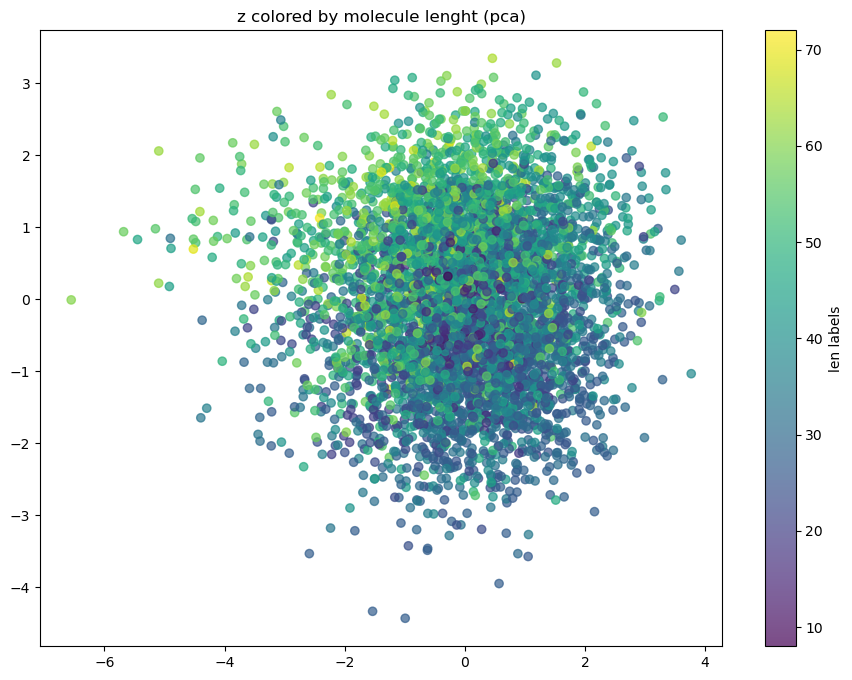

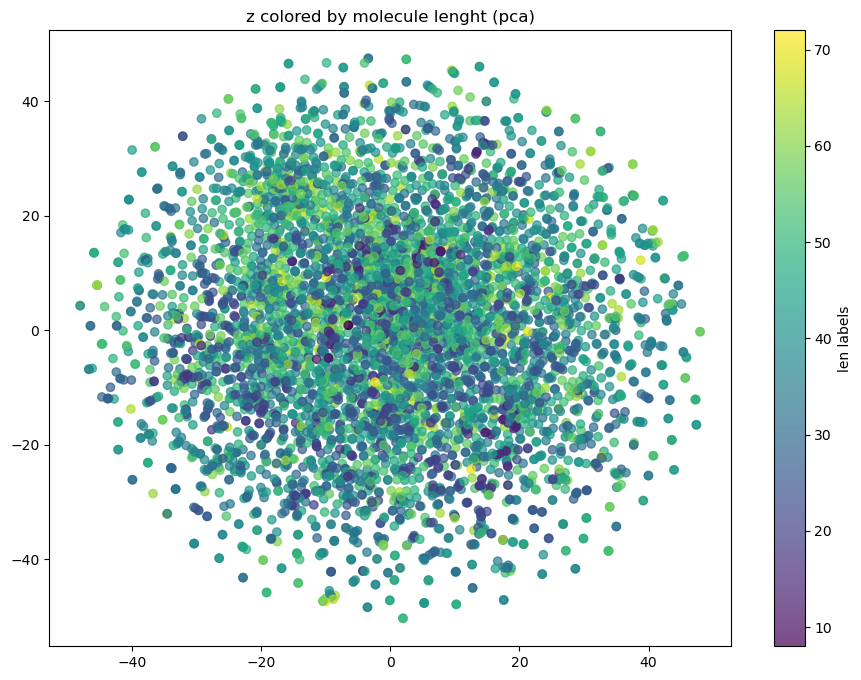

In [ ]:
n_samples = 5000
idxs = np.random.choice(z.shape[0], size=n_samples, replace=False)
z_sample = z[idxs]
len_labels = len_labels = np.array(df['lenghts'])[idxs]
z_sample.shape

pca_z = PCA(n_components=2).fit_transform(z_sample)
plt.figure(figsize=(11,8))
plt.scatter(pca_z[:, 0], pca_z[:, 1], c=len_labels, cmap='viridis', alpha=0.7)
plt.title(label='z colored by molecule lenght (pca)')
plt.colorbar(label='len labels')

tsne_z = TSNE(n_components=2).fit_transform(z_sample)
plt.figure(figsize=(11,8))
plt.scatter(tsne_z[:, 0], tsne_z[:, 1], c=len_labels, cmap='viridis', alpha=0.7)
plt.title(label='z colored by molecule lenght (pca)')
plt.colorbar(label='len labels')
plt.show()

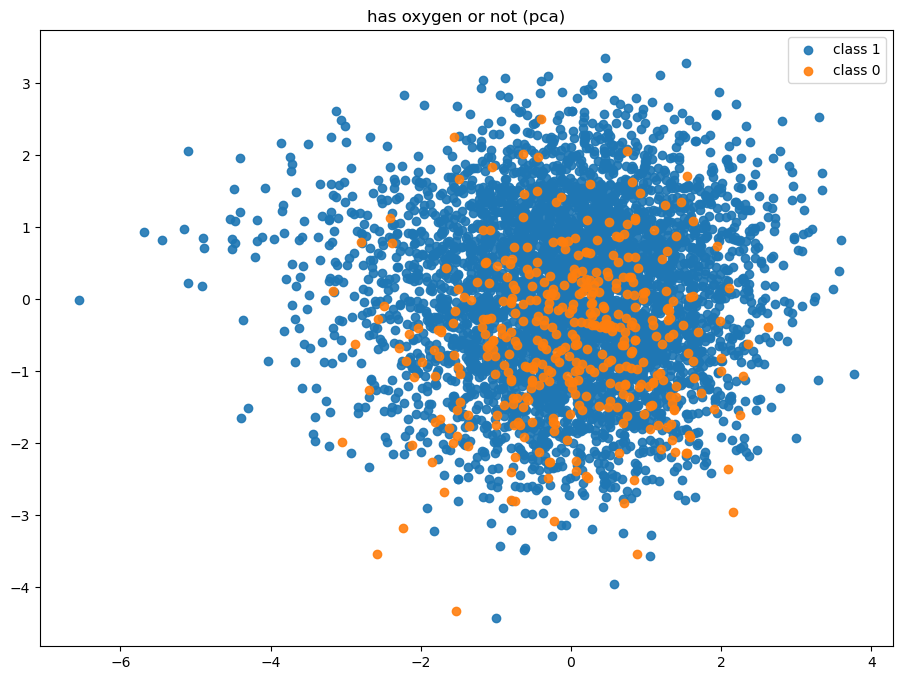

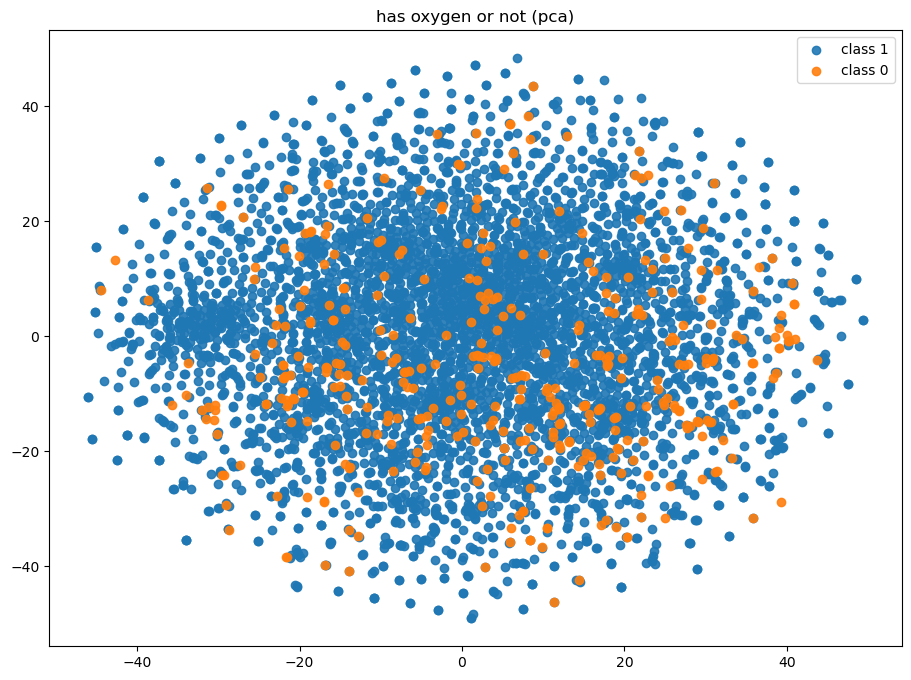

In [14]:
oxygen_labels = df['selfies'].apply(lambda x: 1 if 'O' in x else 0)[idxs]

pca_z = PCA(n_components=2).fit_transform(z_sample)
plt.figure(figsize=(11,8))
for cls in np.unique(oxygen_labels)[::-1]:
    idx = (oxygen_labels == cls)
    plt.scatter(pca_z[idx, 0], pca_z[idx, 1], label=f"class {cls}", alpha=0.9)
plt.title('has oxygen or not (pca)')
plt.legend()
plt.show()

tsne_z = TSNE().fit_transform(z_sample)
plt.figure(figsize=(11,8))
for cls in np.unique(oxygen_labels)[::-1]:
    idx = (oxygen_labels == cls)
    plt.scatter(tsne_z[idx, 0], tsne_z[idx, 1], label=f"class {cls}", alpha=0.9)
plt.title('has oxygen or not (pca)')
plt.legend()
plt.show()

In [15]:
# PCA to 3 components
pca = PCA(n_components=3)
pca_z = pca.fit_transform(z_sample)

fig = px.scatter_3d(
    x=pca_z[:,0],
    y=pca_z[:,1],
    z=pca_z[:,2],
    color=len_labels,
    color_continuous_scale='Viridis',
    opacity=0.7,
    title='z colored by molecule length (PCA 3D)'
)

fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    width=900,
    height=700
)

fig.show()

### Latent traversals and sampling

In [71]:
@torch.no_grad()
def sample_and_validate(model, n_samples, id2tok, sos_id=1, pad_id=0, eos_id=2, device='cuda', latent_scale=1.0):
    model.eval()
    
    B = n_samples
    z = latent_scale * torch.randn(B, latent_size, device=device)
    
    outputs, pred_len = model.decode(z, mode='eval', sos_id=sos_id)
    
    smiles_list = []
    valid_flags = []
    selfies_list = []
    
    for i, logit in enumerate(outputs):
        pred_tokens = torch.argmax(logit, dim=-1).cpu().tolist()
        
        L_pred = len(pred_tokens)
        true_len = max(1, int(torch.round(pred_len[i]).item()))
        if L_pred < true_len:
            pred_tokens += [pad_id] * (true_len - L_pred)
        else:
            pred_tokens = pred_tokens[:true_len]
        
        pred_tokens = [id2tok[t] for t in pred_tokens if t not in [pad_id, sos_id, eos_id]]
        
        selfies_str = ''.join(pred_tokens)
        
        try:
            smiles = sf.decoder(selfies_str)
            mol = Chem.MolFromSmiles(smiles)
            is_valid = mol is not None
        except:
            smiles = None
            is_valid = False
        
        smiles_list.append(smiles)
        valid_flags.append(is_valid)
        selfies_list.append(selfies_str)
    
    valid_ratio = sum(valid_flags) / len(valid_flags)
    return smiles_list, valid_flags, valid_ratio, selfies_list


smiles, valid, ratio, sf_list = sample_and_validate(
    model,
    n_samples=100,
    id2tok=id2tok,
    sos_id=1,
    pad_id=0,
    eos_id=2,
    device=device,
    latent_scale=1  # can scale if you want more exploration
)

print("Validity:", ratio)
for s, v in zip(smiles[:100], valid[:100]):
    print(v, s)

print(sf_list)
print(smiles)

Validity: 1.0
True C1COC(C)CC2C1C=CC#C2
True CC=CC(C[C@@H1]OC=C(C1)CC[C@H1])(OO)C(C)COC2C=CC1=C=C2C
True C
True N1CC=CC#C1
True O=CC=C=C=CCBr
True C=C=C=CCCCCN=C=C=CCCCN=C=C=CC=C=C=CCCCC=CC=C=C=C=CC
True CC=C=CC(C)C(C)=O
True CCCNCC=O
True C12C[NH1]C3(OS=C1)C4CN2NCC5C=CC=C=C5OC=NC=CC=C34
True O=C=CCCCCC=CC(C)=CS
True CCCCCCCCCCCCCCCC(C)CCC
True CC1C(C)C=C=N1
True CC1C#C1
True O1C(C)CCCC=CC(O)C1[NH1]
True N1CCC2CCCCCC1(O3)C3(C)CCC2
True CCCC(C)C1CCCCCOC1C=C
True CC(OOCCCC1=CC)CC=N1
True C=C(COC[C@@H1])C(C)CCCCC=COCCF
True CCCCCCCCCCCC
True CCC=CCCCCC1C=N1
True C#CC=C
True CCCC(C)=C=CC#CC=N
True CCCCCCCCC=C
True NCC=CC1=C=C1C(C)C
True CCCC=C=C(C)CCCC
True CCCC1=CC=CCSCNC1CCCCN2CC2NCCC3CC=C(C)C3
True CCCCCCCC
True O1OC2C(C3)CC1C=CC=CC=C2C=C3CC
True CCCCC
True O=C=CCC(C)C#CC
True OOCCCC#CC=CC=C[NH1]N=CCC=CCC=C
True COC=CCOC
True CCC#CC=CC=C
True OC=C=C=C(C)N=C1N=C1
True CCCCCCCCCCCCCCCCCCC
True C12CC1=CCC2C
True CCCC(CCCCl)C(C)=CC(C=CSN=CCCCCCCCCCC)C
True CCC(C)CC=CC(C)NN=CC=CN
True CCCCCC

In [72]:
def decode_ids(logits):
    # unwrap lists/tuples
    if isinstance(logits, (list, tuple)):
        logits = logits[-1]  # take final logits

    logits = torch.as_tensor(logits)

    if logits.dim() == 3:      # [B, T, V]
        logits = logits[0]
    if logits.dim() == 2:      # [T, V]
        ids = logits.argmax(dim=-1)
    else:                      # [V]
        ids = logits.argmax().unsqueeze(0)

    return ids.cpu().tolist()

def count_duplicates(lst):
    if not lst:
        return [], []
    unique = [lst[0]]
    counts = [1]
    for x in lst[1:]:
        if x == unique[-1]:
            counts[-1] += 1
        else:
            unique.append(x)
            counts.append(1)
    return unique, counts

def ids_to_smiles(ids, id2tok):
    toks = [id2tok[i] for i in ids]
    toks = [t for t in toks if t not in ("<SOS>", "PAD")]
    if "<EOS>" in toks:
        toks = toks[:toks.index("<EOS>")]

    selfies = "".join(toks)
    try:
        smiles = sf.decoder(selfies)
        return smiles if Chem.MolFromSmiles(smiles) else None
    except:
        return None

def latent_traversal(model, x, dim=0, steps=50, max_delta=5.0):
    model.eval()
    with torch.no_grad():
        mu, _ = model.encode(x.unsqueeze(0).to(device))
    z0 = mu[0]

    xs = torch.linspace(-max_delta, max_delta, steps)
    valids = []

    for s in xs:
        z = z0.clone()
        z[dim] += s
        logits, _ = model.decode(z.unsqueeze(0))
        ids = decode_ids(logits)
        smiles = ids_to_smiles(ids, id2tok)
        valids.append(smiles is not None)
        if smiles:
            print(smiles)

def get_logits(decoder_out):
    if isinstance(decoder_out, (tuple, list)):
        decoder_out = decoder_out[0]
        if isinstance(decoder_out, (tuple, list)):
            decoder_out = decoder_out[-1]
    return torch.as_tensor(decoder_out)

def decode_ids_from_logits(logits):
    if logits.dim() == 3:
        logits = logits[0]
    if logits.dim() == 2:
        ids = logits.argmax(dim=-1)
    else:
        ids = logits.argmax().unsqueeze(0)
    return ids.cpu().tolist()

def latent_random_traversal(model, data, steps=300, sigma=0.01):
    model.eval()
    x = torch.tensor(data[np.random.randint(len(data))]).to(device)

    with torch.no_grad():
        mu, _ = model.encode(x.unsqueeze(0))
        z = mu.clone()

    smiles_seq = []

    for _ in range(steps):
        z = z + sigma * torch.randn_like(z)

        dec_out = model.decode(z)
        logits = get_logits(dec_out)
        ids = decode_ids_from_logits(logits)
        smiles = ids_to_smiles(ids, id2tok)

        if smiles is not None:
            smiles_seq.append(smiles)

    unique, counts = count_duplicates(smiles_seq)

    print("Random walk segments:")
    for s, c in zip(unique, counts):
        print(f"{s}  {c}")

def latent_linear_traversal(model, val_data, steps=40):
    model.eval()

    # pick two random molecules
    x1 = torch.tensor(val_data[np.random.randint(len(val_data))]).to(device)
    x2 = torch.tensor(val_data[np.random.randint(len(val_data))]).to(device)

    with torch.no_grad():
        z1, _ = model.encode(x1.unsqueeze(0))
        z2, _ = model.encode(x2.unsqueeze(0))

    alphas = torch.linspace(0, 1, steps)
    smiles_seq = []

    for a in alphas:
        z = (1 - a) * z1 + a * z2
        dec_out = model.decode(z)
        logits = get_logits(dec_out)
        ids = decode_ids_from_logits(logits)
        smiles = ids_to_smiles(ids, id2tok)
        if smiles is not None:
            smiles_seq.append(smiles)

    unique, counts = count_duplicates(smiles_seq)

    print("Linear interpolation:")
    for s, c in zip(unique, counts):
        print(f"{s}  |  {c} steps")

In [73]:
latent_traversal(model, torch.tensor(train_data[np.random.randint(0,len(train_data))]), dim=1, steps=100, max_delta=20)

CC(C)(C)CC(=O)NC1=CC=C2C(C=CN2CC3=CC=C(Cl)S3)=C1
CC(C)(C)CC(=O)NC1=CC=C2C(C=CN2CC3=CC=C(Cl)S3)=C1
CC(C)(C)CC(=O)NC1=CC=C2C(C=CN2CC3=CC=C(Cl)S3)=C1
CC(C)(C)CC(=O)NC1=CC=C2C(C=CN2CC3=CC=C(Cl)S3)=C1
CC(C)(C)CC(=O)NC1=CC=C2C(C=CN2CC3=CC=C(Cl)S3)=C1
CC(C)(C)CC(=O)NC1=CC=C2C(C=CN2CC3=CC=C(Cl)S3)=C1
CC(C)(C)CC(=O)NC1=CC=C2C(C=CN2CC3=CC=C(Cl)S3)=C1
CC(C)(C)CC(=O)NC1=CC=C2C(C=CN2CC3=CC=C(Cl)S3)=C1
CC(C)(C)CC(=O)NC1=CC=C2C(C=CN2CC3=CC=C(Cl)S3)=C1
CC(C)(C)CC(=O)NC1=CC=C2C(C=CN2CC3=CC=C(Cl)S3)=C1
CC(C)(C)CC(=O)NC1=CC=C2C(C=CN2CC3=CC=C(Cl)S3)=C1
CC(C)(C)CC(=O)NC1=CC=C2C(C=CN2CC3=CC=C(Cl)S3)=C1
CC(C)(C)CC(=O)NC1=CC=C2C(C=CN2CC3=CC=C(Cl)S3)=C1
CC(C)(C)CC(=O)NC1=CC=C2C(C=CN2CC3=CC=C(Cl)S3)=C1
CC(C)(C)CC(=O)NC1=CC=C2C(C=CN2CC3=CC=C(Cl)S3)=C1
CC(C)(C)CC(=O)NC1=CC=C2C(C=CN2CC3=CC=C(Cl)S3)=C1
CC(C)(C)CC(=O)NC1=CC=C2C(C=CN2CC3=CC=C(Cl)S3)=C1
CC(C)(C)CC(=O)NC1=CC=C2C(C=CN2CC3=CC=C(Cl)S3)=C1
CC(C)(C)CC(=O)NC1=CC=C2C(C=CN2CC3=CC=C(Cl)S3)=C1
CC(C)(C)CC(=O)NC1=CC=C2C(C=CN2CC3=CC=C(Cl)S3)=C1
CC(C)(C)CC(=O)NC1=CC

In [75]:
latent_random_traversal(model, val_data, steps=30, sigma=0.1)

Random walk segments:
CCOC(=O)NC1=CC=CC(CC2=NN(C3=CC(F)=C(F)C(F)=C3)C=CC2=O)=C1  15
C1COC(=O)N2C=CC=CC(CC=NN1C3=CC(F)=C(F)C(F)=C3C=CC)=C2  1
CCOC(=O)NC1=CC=CC(CC2=NN(C3=CC(F)=C(F)C(F)=C3)C=CC2=O)=C1  1
CCOC(=O)NC1=CC=CC(CC2=NN(C3=CC(F)=C(F)C(F)=C3)C=CC2C)=C1  1
CCOC(=O)NC1=CC=CC(CC2=NN(C3=CC(F)=C(F)C(F)=C3)C=CC2=O)=C1  1
CCOC(=O)CC1=CC=CC(CC=NN1C=CC(F)=C(F)CCCF)=C  1
CCOC(N)CC=C1C=CC(CC=NN(C=CC(F)=C(F)CCCF)C=CCC)=C1  2
CCOC(N)CC=CC=CC(CC1=NN(C=CC(F)=C(F)CCCF)C=CCC)=C1  1
CCOCCCNCC=C1C=CC(CC=NN(C=CC(F)=C(F)CCCF)C=CCC)=C1  1
CCOC(N)CC=C1C=CC(CC=NN(C=CC(F)=C(F)CCCF)C=CCC)=C1  1
CCOCCCNCC=C1C=CC(CC=NN(C=CC(F)=C(F)CCCF)C=CCC)=C1  1
CCOCCCNCC=C1C=CC(CCON(C=CC(F)=C(F)CCCF)C=CCC)=C1  1
CCOCCCNCC=C1C=CC(CC=NN(C=CC(F)=C(F)CCCF)C=CCC)=C1  1
CC(C)CNC(C=CCCC=NN(C=CC(F)=C(F)CCCF)C=CCC)=C  1
CC(C)CNN(C=CCCC=NN(C=CC(F)=C(F)CCCF)C=CCC)C  1


In [77]:
latent_linear_traversal(model, val_data, steps=40)

Linear interpolation:
O=C(NCC1=CC=CC=N1)C2=CC=NC=C2  |  11 steps
O=C(NCC1=CC=CC=N1)C=CC=NC#C  |  2 steps
O=C(NCC1=CC=CC=N1)C=CC=NC=C  |  3 steps
O=C(NCC=CC=CC#N)C=CC=NC#C  |  1 steps
C=C(NCC=CC=CC#N)C=CC=NC#C  |  1 steps
CC(NCCCC1=CC1C)C2=CC=NC=C2  |  1 steps
CC(NCCCC1=CC1C)C2=CC=NC=C2CC  |  1 steps
CCNCCCCCCC1=CC=NC=C1CCCOC  |  1 steps
C12C(NCCC1(C)C)C=CC=NC=C2C3CCOCC3  |  1 steps
CC(N)CCC(C)C=CC=NC=NC(C1CCOCC1)=NC  |  1 steps
CC(N)CCC(C)N=CC=NC=NC(N1CCOCC1)=NCNCCO  |  1 steps
CC(N)CCC(C)N=CC=NC=NC(N1CCOCC1)=NCN2CCOCC2  |  1 steps
C1C(N)CCC1(C)CN=C2NC(N3CCOCC3)=NC(N4CCOCC4)=N2  |  1 steps
C1CCCNCCC(C)(CN=C1)C2=NC(N3CCOCC3)=NC(N4CCOCC4)=N2  |  3 steps
C1CCCNCCC(C)(C)N=C1C2=NC(N3CCOCC3)=NC(N4CCOCC4)=N2  |  1 steps
CCCCNCCC(C)(C)N(C1=NC(N2CCOCC2)=NC(N3CCOCC3)=N1)C(C)(C4)C4  |  1 steps
CCCCNCCC(C)(C)N(C1=NC(N2C3COCC2)=NC(N4CCOCC4)=N1)C(C)(C)C3  |  1 steps
CCCCNC1CC(C)(C)N(C2=NC(N3CCOCC3)=NC(N4CCOCC4)=N2)C(C)(C)C1  |  8 steps


In [22]:
pos_to_probe = 17  
latents = []
targets = []

for x in tqdm(val_data):
    x_tensor = torch.tensor(x).unsqueeze(0).to(device)
    with torch.no_grad():
        mu, _ = model.encode(x_tensor)
    z = mu.squeeze(0).cpu().numpy()       # [latent_dim]

    if pos_to_probe < len(x):
        token_id = x[pos_to_probe]
        latents.append(z)
        targets.append(token_id)

latents = np.stack(latents)   # [N, latent_dim]
targets = np.array(targets)   # [N]

X_train, X_test, y_train, y_test = train_test_split(
    latents, targets, test_size=0.2, random_state=42
)

ridge = Ridge(alpha=1.0)  # L2 regularization
ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)
y_pred_ids = np.round(y_pred).astype(int)  # round to nearest token ID
y_pred_ids = np.clip(y_pred_ids, 0, len(id2tok)-1)

acc = (y_pred_ids == y_test).mean()
print(f"Prediction accuracy for token at position {pos_to_probe}: {acc:.4f}")

  8%|▊         | 6710/79440 [00:03<00:36, 1970.57it/s]


KeyboardInterrupt: 

### Visualisations and Tests from papers

In [78]:
def cleaned_selfie(tokens, pad="<PAD>", sos="<SOS>", eos="<EOS>"):
    out = []
    for t in tokens:
        if t == eos:
            break
        if t in (pad, sos):
            continue
        out.append(t)
    return out

def decode_z_to_smiles(model, z):
    with torch.no_grad():
        out = model.decode(z.unsqueeze(0))
    logits = out[0] if isinstance(out, tuple) else out
    ids = logits[0].argmax(dim=-1).cpu().tolist()
    toks = cleaned_selfie([id2tok[i] for i in ids])
    try:
        smi = sf.decoder("".join(toks))
        mol = Chem.MolFromSmiles(smi)
        return smi if mol is not None else None
    except:
        return None

from rdkit.Chem import Draw, AllChem, DataStructs
from IPython.display import display
import torch
import numpy as np

def mol_distance(mol1, mol2, radius=2, nBits=2048):
    if mol1 is None or mol2 is None:
        return None
    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, radius, nBits)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, radius, nBits)
    return 1.0 - DataStructs.TanimotoSimilarity(fp1, fp2)

def latent_grid_unique_plot(
    model,
    x,
    dim_x=0,
    dim_y=1,
    grid_size=7,
    delta=2.0,
    noise=0.05,
    mol_size=(200, 200)
):
    model.eval()

    # ---- True molecule from dataset ----
    true_ids = x.cpu().tolist()
    true_toks = cleaned_selfie([id2tok[i] for i in true_ids])
    true_smi = sf.decoder("".join(true_toks))
    true_mol = Chem.MolFromSmiles(true_smi)

    print("True molecule from dataset:", true_smi)
    display(Draw.MolToImage(true_mol, size=(300, 300)))

    # ---- Encode seed ----
    with torch.no_grad():
        mu, _ = model.encode(x.unsqueeze(0).to(device))
    z0 = mu[0]

    seed_smi = decode_z_to_smiles(model, z0)
    seed_mol = Chem.MolFromSmiles(seed_smi) if seed_smi else None

    print("Decoded seed molecule:", seed_smi)
    display(Draw.MolToImage(seed_mol, size=(300, 300)))

    # ---- Latent grid ----
    offsets = torch.linspace(-delta, delta, grid_size)

    mols = []
    legends = []
    seen = {}

    for iy, dy in enumerate(offsets):
        for ix, dx in enumerate(offsets):
            z = z0.clone()
            z[dim_x] += dx
            z[dim_y] += dy
            z += torch.randn_like(z) * noise

            smi = decode_z_to_smiles(model, z)
            if smi is None:
                mols.append(None)
                legends.append("")
                continue

            if smi not in seen:
                seen[smi] = Chem.MolFromSmiles(smi)

            mol = seen[smi]
            mols.append(mol)

            if seed_mol is not None:
                d = mol_distance(seed_mol, mol)
                legends.append(f"d={d:.2f}")
            else:
                legends.append("")

    # Mark center cell
    center = (grid_size * grid_size) // 2
    legends[center] = "SEED\n" + legends[center]

    img = Draw.MolsToGridImage(
        mols,
        molsPerRow=grid_size,
        subImgSize=mol_size,
        legends=legends
    )

    display(img)

In [79]:
model.eval()
with torch.no_grad():
    latents = []
    for x in tqdm(val_data):
        x = torch.tensor(x).unsqueeze(0).to(device)
        mu, _ = model.encode(x)
        latents.append(mu.cpu().numpy())
latents = np.vstack(latents)

pca = PCA(n_components=8)
pca.fit(latents)

100%|██████████| 79440/79440 [00:45<00:00, 1738.08it/s]


,n_components,8
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


True molecule from dataset: O=S(=O)(C1=CC=CC=C1)N2N=CC3=C(C4=NC=C(CO)O4)C=C(Cl)C=C32


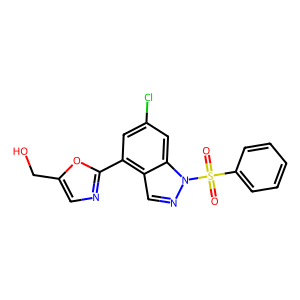

Decoded seed molecule: O=S(=O)(C1=CC=CC=C1)N2N=CC3=C(C4=NC=C(CO)O4)C=C(Cl)C=C32


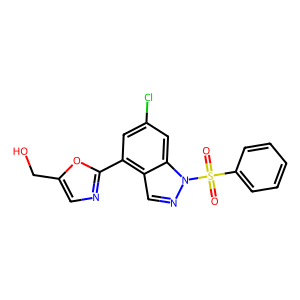

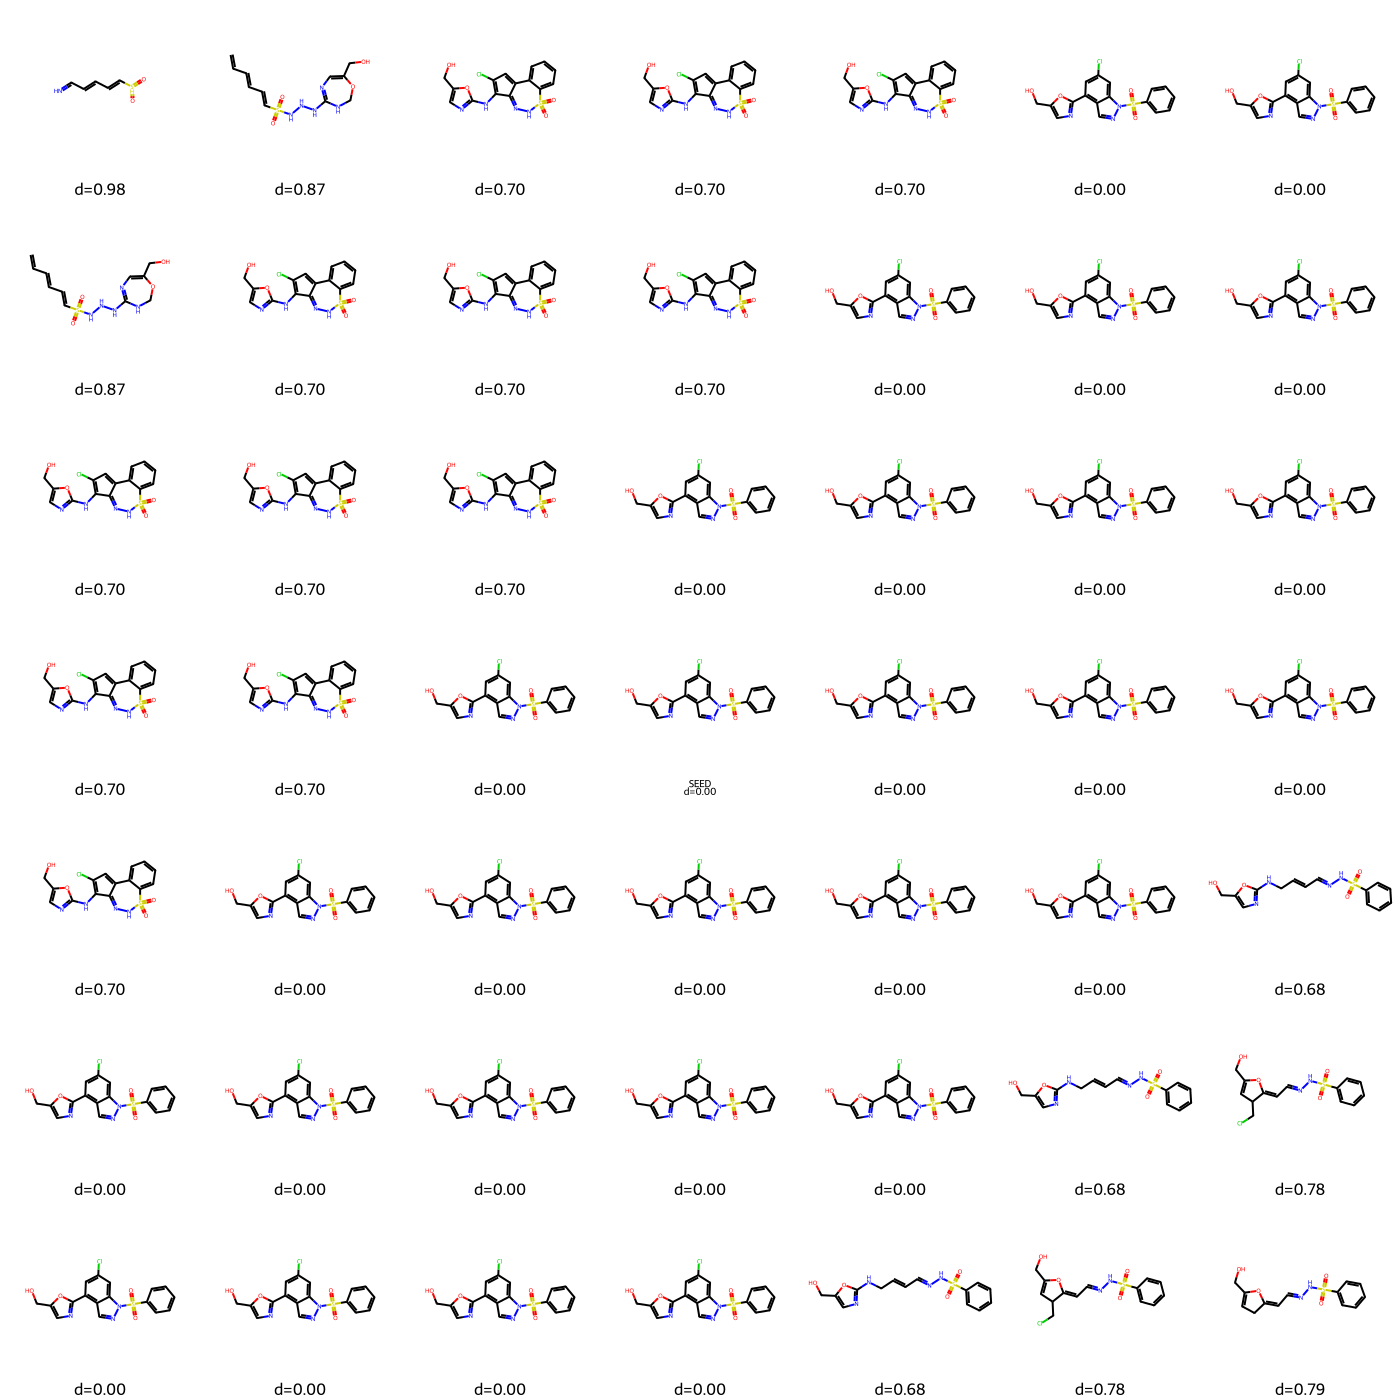

In [83]:
x = torch.tensor(val_data[np.random.randint(len(val_data))])
latent_grid_unique_plot(
    model,
    x,
    dim_x=pca.components_[0],
    dim_y=pca.components_[1],
    grid_size=7,
    delta=7,
    noise=0
)

In [84]:
molecule_groups = {
    "alkanes": [
        "C",        # methane
        "CC",       # ethane
        "CCC",      # propane
        "CCCC",     # butane
      #  "CCCCC"     # pentane
    ],
    "alcohols": [
        "CO",       # methanol
        "CCO",      # ethanol
        "CCCO",     # propanol
        "CCCCO"     # butanol
    ],
    # "amines": [
    #     "CN",       # methylamine
    #     "CCN",      # ethylamine
    #     "CCCN"
    # ],
    # "acids": [
    #     "C(=O)O",        # formic acid
    #     "CC(=O)O",       # acetic acid
    #     "CCC(=O)O"
    # ]
}

def smiles_to_ids(smiles, tok2id, max_len):
    selfies = sf.encoder(smiles)
    tokens = list(sf.split_selfies(selfies))
    ids = [tok2id["<SOS>"]] + [tok2id[t] for t in tokens] + [tok2id["<EOS>"]]
    
    padded = np.zeros(max_len, dtype=np.int64)
    padded[:len(ids)] = ids
    return padded

def encode_groups(model, molecule_groups, tok2id, max_len, device):
    model.eval()
    Z = []
    labels = []
    names = []

    with torch.no_grad():
        for group, smiles_list in molecule_groups.items():
            for smi in smiles_list:
                x = smiles_to_ids(smi, tok2id, max_len)
                x = torch.tensor(x).unsqueeze(0).to(device)

                mu, logvar = model.encode(x)
                z = mu.squeeze(0).cpu().numpy()

                Z.append(z)
                labels.append(group)
                names.append(smi)

    return np.vstack(Z), labels, names

def plot_pca(Z, labels, names):
    pca = PCA(n_components=2)
    Z2 = pca.fit_transform(Z)

    plt.figure(figsize=(8, 6))

    for group in sorted(set(labels)):
        idx = [i for i, g in enumerate(labels) if g == group]
        plt.scatter(
            Z2[idx, 0],
            Z2[idx, 1],
            label=group,
            s=80
        )

    # annotate points
    for i, name in enumerate(names):
        plt.text(Z2[i, 0], Z2[i, 1], name, fontsize=9)

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Latent space PCA – chemical semantics")
    plt.legend()
    plt.grid(True)
    plt.show()

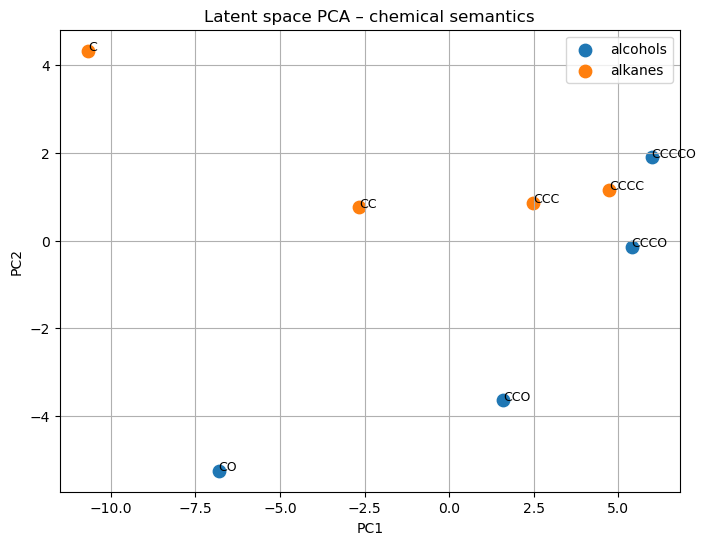

In [85]:
Z, labels, names = encode_groups(
    model,
    molecule_groups,
    tok2id,
    max_len,
    device
)

plot_pca(Z, labels, names)

In [32]:
def latent_distances(model, smiles_list, tok2id, max_len, device):
    zs = []
    with torch.no_grad():
        for s in smiles_list:
            x = smiles_to_ids(s, tok2id, max_len)
            x = torch.tensor(x).unsqueeze(0).to(device)
            mu, _ = model.encode(x)
            zs.append(mu.squeeze(0).cpu().numpy())

    dists = []
    for i in range(len(zs) - 1):
        dists.append(np.linalg.norm(zs[i+1] - zs[i]))

    return dists


alkanes = ["C", "CC", "CCC", "CCCC", "CCCCC", "CCCCCC", "CCCCCCC"]
print("Alkane latent distances:", latent_distances(
    model, alkanes, tok2id, max_len, device
))
alcohols = ["CO", "CCO", "CCCO", "CCCCO", "CCCCCO", "CCCCCCO", "CCCCCCCO"]
print("Alcohols latent distances:", latent_distances(
    model, alcohols, tok2id, max_len, device
))
amines = ["CN", "CCN", "CCCN", "CCCCN", "CCCCCN", "CCCCCCN", "CCCCCCCN"]
print("Amines latent distances:", latent_distances(
    model, amines, tok2id, max_len, device
))
acids = ["C(=O)O", "CC(=O)O", "CCC(=O)O", "CCCC(=O)O", "CCCCC(=O)O", "CCCCCC(=O)O", "CCCCCCC(=O)O"]
print("Acids latent distances:", latent_distances(
    model, alcohols, tok2id, max_len, device
))

Alkane latent distances: [7.0676155, 4.693921, 3.7242346, 2.6598659, 4.422829, 4.0206265]
Alcohols latent distances: [7.223664, 5.711013, 4.4357066, 5.2472453, 5.529375, 5.2411914]
Amines latent distances: [7.643608, 6.0223246, 4.216308, 4.7555184, 5.5914173, 5.4370065]
Acids latent distances: [7.223664, 5.711013, 4.4357066, 5.2472453, 5.529375, 5.2411914]


In [35]:
def latent_vector(model, s1, s2, tok2id, max_len, device):
    with torch.no_grad():
        def enc(s):
            x = smiles_to_ids(s, tok2id, max_len)
            x = torch.tensor(x).unsqueeze(0).to(device)
            mu, _ = model.encode(x)
            return mu.squeeze(0)

    return enc(s1) - enc(s2)

v1 = latent_vector(model, "CCCO", "CCC", tok2id, max_len, device)
v2 = latent_vector(model, "CCCCO", "CCCC", tok2id, max_len, device)

cos_sim = torch.nn.functional.cosine_similarity(v1, v2, dim=0)
print("Cosine similarity (OH direction):", cos_sim.item())

Cosine similarity (OH direction): 0.5895179510116577
